# Variational AutoEncoders on Fashion MNIST

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/03_vae/03_vae_faces/vae_faces.ipynb), Lincense: Apache-2.0 

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import utils

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.training import train_state, orbax_utils
import optax
import orbax.checkpoint

## 0. Train parameters

In [2]:
DATA_DIR = '../../data/CelebFaces/img_align_celeba/img_align_celeba/'
DATA_FOlDER = '../../data/CelebFaces/'
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
EMBEDDING_DIM = 200
LEARNING_RATE = 5e-4
EPOCHS = 15
BETA = 1.2
VALID_SPLIT = 0.2

## 1. Prepare dataset

In [3]:
# Preprocess the image
def preprocess(img):
    img = tf.cast(img, tf.float32) / 255.
    return img

# Load CelebA dataset from directory
def get_dataset():
    # read image files from directory
    train_ds, test_ds = utils.image_dataset_from_directory(
        directory=DATA_DIR,
        labels=None,
        color_mode='rgb',
        batch_size=None,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        interpolation='bilinear',
        validation_split=VALID_SPLIT,
        seed=1024,
        subset='both'
    )
    
    train_ds = train_ds.map(lambda sample: preprocess(sample))
    train_ds = train_ds.repeat(EPOCHS).shuffle(1024)
    train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)
    
    test_ds = test_ds.map(lambda sample: preprocess(sample))
    test_ds = test_ds.shuffle(1024)
    test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

    return train_ds, test_ds

Found 202599 files belonging to 1 classes.
Using 162080 files for training.
Using 40519 files for validation.


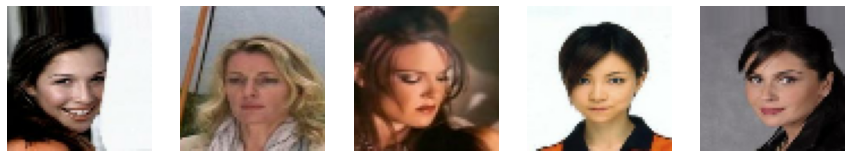

In [4]:
# Check dataset
check_ds, _ = get_dataset()
check_samples = next(iter(check_ds))

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(check_samples[i])
    axes[i].axis('off')
plt.show()

## 2. Building the Variational AutoEncoder

In [5]:
# Encoder
class Encoder(nn.Module):
    latents: int
    num_blocks: int = 5 # The encoder has 5 identical Conv-BatchNorm-LeakyReLU blocks
    @nn.compact
    
    def __call__(self, x, train:bool):
        for i in range(self.num_blocks):
            x = nn.Conv(features=NUM_FEATURES, kernel_size=(3, 3), strides=2)(x)
            x = nn.BatchNorm(use_running_average=not train)(x)
            x = nn.leaky_relu(x)

        x = x.reshape(x.shape[0], -1)
        mean_x = nn.Dense(features=self.latents, name='z_mean')(x)
        logvar_x = nn.Dense(features=self.latents, name='z_logvar')(x)
        return mean_x, logvar_x

# Uncomment the following two lines of code to check Encoder structure
# encoder = Encoder(EMBEDDING_DIM)
# print(encoder.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 64, 64, 3)), console_kwargs={'width': 120}, train=False))


# Decoder
class Decoder(nn.Module):
    num_blocks: int = 5
    
    @nn.compact
    def __call__(self, x, train:bool):
        x = nn.Dense(features=256)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = nn.leaky_relu(x)
        x = x.reshape(x.shape[0], 2, 2, 64)

        for i in range(self.num_blocks):
            x = nn.ConvTranspose(features=NUM_FEATURES, kernel_size=(3, 3), strides=(2, 2))(x)
            x = nn.BatchNorm(use_running_average=not train)(x)
            x = nn.leaky_relu(x)

        x = nn.Conv(features=CHANNELS, kernel_size=(3, 3), strides=1)(x)
        x = nn.sigmoid(x)
        
        return x

# Uncomment the following two lines of code to check Decoder structure
# decoder = Decoder()
# print(decoder.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 200)), console_kwargs={'width': 120}, train=False))

In [6]:
# Reparameterization trick
def reparameterize(rng, mean, logvar):
    std = jnp.exp(0.5 * logvar)
    eps = jax.random.normal(rng, logvar.shape)
    return mean + eps * std

# Variational AutoEncoder
class VAE(nn.Module):
    latents: int

    def setup(self):
        self.encoder = Encoder(self.latents)
        self.decoder = Decoder()

    def __call__(self, x, z_rng, train:bool):
        mean, logvar = self.encoder(x, train)
        z = reparameterize(z_rng, mean, logvar)
        recon_x = self.decoder(z, train)
        return recon_x, mean, logvar

In [7]:
# Print out model structure
vae = VAE(EMBEDDING_DIM)
rng = jax.random.PRNGKey(0)
tabulate_fn = nn.tabulate(vae, rng, console_kwargs={'width': 120})

rng, key = jax.random.split(rng)
x = jnp.ones((1, 64, 64, 3))
print(tabulate_fn(x, key, False))


                                                      VAE Summary                                                       
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path               ┃ module        ┃ inputs             ┃ outputs           ┃ batch_stats        ┃ params            ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│                    │ VAE           │ -                  │ -                 │                    │                   │
│                    │               │ float32[1,64,64,3] │ float32[1,64,64,… │                    │                   │
│                    │               │ - uint32[2]        │ - float32[1,200]  │                    │                   │
│                    │               │ - False            │ - float32[1,200]  │                    │                   │
├────────────────────┼─────────

### Loss function

In [8]:
@jax.vmap
def mse(recons_x, x):
    return ((recons_x - x) ** 2).sum()

@jax.vmap
def kl_divergence(mean, logvar):
    return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

## 3. Create a `TrainState`

In [9]:
from typing import Any

class TrainState(train_state.TrainState):
    batch_stats: Any # For BatchNorm layers


def create_train_state(model, rng, learning_rate):
    # Initialize the model
    rng, key = jax.random.split(rng)
    variables = model.init(rng, jnp.ones([1, 64, 64, 3]), key, train=False)
    params = variables['params']
    batch_stats = variables['batch_stats']

    # Initialize optimizer
    tx = optax.adam(learning_rate=LEARNING_RATE)
    return TrainState.create(
        apply_fn=model.apply,
        params=params,
        batch_stats=batch_stats,
        tx=tx)

## 4. Train step

In [10]:
@jax.jit
def train_step(state, batch, z_rng):
    def loss_fn(params):
        (recon_x, mean, logvar), updates = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats},
            batch,
            z_rng=z_rng,
            train=True,
            mutable=['batch_stats']
        )

        mse_loss = mse(recon_x, batch).mean()
        kl_loss = kl_divergence(mean, logvar).mean()
        loss = mse_loss + BETA * kl_loss
        return loss, updates
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, updates), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    state = state.replace(batch_stats=updates['batch_stats'])
    return state

In [11]:
@jax.jit
def compute_metrics(*, state, batch, z_rng):
    recon_x, mean, logvar = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        batch,
        z_rng=z_rng,
        train=False
    )
    mse_loss = mse(recon_x, batch).mean()
    kl_loss = kl_divergence(mean, logvar).mean()
    return mse_loss, kl_loss, recon_x

## 5. Load dataset and initialize the model

In [12]:
train_ds, test_ds = get_dataset()

tf.random.set_seed(0)
rng = jax.random.PRNGKey(0)

vae = VAE(EMBEDDING_DIM)
state = create_train_state(vae, rng, LEARNING_RATE)

Found 202599 files belonging to 1 classes.
Using 162080 files for training.
Using 40519 files for validation.


## 6. Train and evaluate

In [13]:
num_steps_per_epoch = train_ds.cardinality().numpy() // EPOCHS

metrics_history = {
    'train_mse_loss': [],
    'train_kl_loss': [],
    'test_mse_loss': [],
    'test_kl_loss': []
}

In [14]:
train_mse_hist = []
train_kl_hist = []
test_mse_hist = []
test_kl_hist = []

prev_time = time.time()
for step, batch in enumerate(train_ds.as_numpy_iterator()):
    
    rng, key = jax.random.split(rng)

    state = train_step(state, batch, key)
    train_mse, train_kl, _ = compute_metrics(state=state, batch=batch, z_rng=rng)
    train_mse_hist.append(train_mse)
    train_kl_hist.append(train_kl)

    if (step + 1) % num_steps_per_epoch == 0:
        metrics_history['train_mse_loss'].append(np.mean(train_mse_hist))
        metrics_history['train_kl_loss'].append(np.mean(train_kl_hist))
        train_mse_hist = []
        train_kl_hist = []

        for test_batch in test_ds.as_numpy_iterator():
            test_mse, test_kl, _ = compute_metrics(state=state, batch=test_batch, z_rng=rng)
            test_mse_hist.append(test_mse)
            test_kl_hist.append(test_kl)

        metrics_history['test_mse_loss'].append(np.mean(test_mse_hist))
        metrics_history['test_kl_loss'].append(np.mean(test_kl_hist))
        test_mse_hist = []
        test_kl_hist = []

        # calculate the time spent each epoch
        curr_time = time.time()
        print('Epoch {}: \tepoch time {:.2f} min'.format(
            (step + 1) // num_steps_per_epoch, 
            (curr_time - prev_time) / 60
        ))
        prev_time = curr_time
        
        print(f'\tTrain - mse_loss: {metrics_history["train_mse_loss"][-1]:.4f}, kl_loss: {metrics_history["train_kl_loss"][-1]:.4f}')
        print(f'\tTest - mse_loss: {metrics_history["test_mse_loss"][-1]:.4f}, kl_loss: {metrics_history["test_kl_loss"][-1]:.4f}')

Epoch 1: 	epoch time 0.80 min
	Train - mse_loss: 3.9051, kl_loss: 0.4286
	Test - mse_loss: 2.2410, kl_loss: 0.4249
Epoch 2: 	epoch time 0.64 min
	Train - mse_loss: 2.0307, kl_loss: 0.4078
	Test - mse_loss: 1.8705, kl_loss: 0.3952
Epoch 3: 	epoch time 0.64 min
	Train - mse_loss: 1.7554, kl_loss: 0.3805
	Test - mse_loss: 1.6783, kl_loss: 0.3764
Epoch 4: 	epoch time 0.64 min
	Train - mse_loss: 1.6413, kl_loss: 0.3767
	Test - mse_loss: 1.5929, kl_loss: 0.3831
Epoch 5: 	epoch time 0.64 min
	Train - mse_loss: 1.5794, kl_loss: 0.3806
	Test - mse_loss: 1.5603, kl_loss: 0.3825
Epoch 6: 	epoch time 0.64 min
	Train - mse_loss: 1.5414, kl_loss: 0.3844
	Test - mse_loss: 1.5184, kl_loss: 0.3909
Epoch 7: 	epoch time 0.64 min
	Train - mse_loss: 1.5135, kl_loss: 0.3873
	Test - mse_loss: 1.5269, kl_loss: 0.3907
Epoch 8: 	epoch time 0.64 min
	Train - mse_loss: 1.4908, kl_loss: 0.3920
	Test - mse_loss: 1.5549, kl_loss: 0.3976
Epoch 9: 	epoch time 0.64 min
	Train - mse_loss: 1.4756, kl_loss: 0.3938
	Test -

In [15]:
# PyTree for saving and loading models
config = {'dimensions': np.array([1, 64, 64, 3]), 'name': 'VAE'}
checkpoint = {'model': state, 'config': config}
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

In [16]:
# Save model
save_args = orbax_utils.save_args_from_target(checkpoint)
orbax_checkpointer.save('./models/', checkpoint, save_args=save_args, force=True)

In [17]:
# Restore model
restored = orbax_checkpointer.restore('./models/')
model = restored['model']

tx = optax.adam(learning_rate=LEARNING_RATE)
state = TrainState.create(
        apply_fn=vae.apply,
        params=model['params'],
        batch_stats=model['batch_stats'],
        tx=tx)

## 7. Reconstruct using the Variational AutoEncoder

In [18]:
rng = jax.random.PRNGKey(0)
recons_batch = next(iter(test_ds)).numpy()
mse_loss, kl_loss, recons_x = compute_metrics(batch=recons_batch, state=state, z_rng=rng)

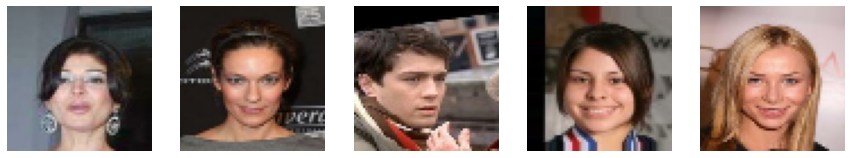

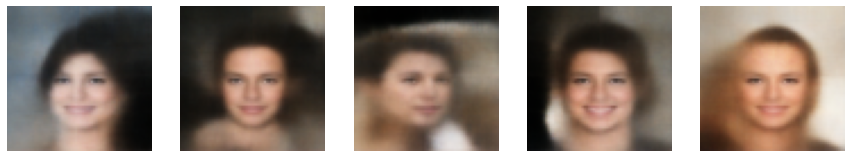

In [19]:
num_plots = 5

fig, axes = plt.subplots(1, num_plots, figsize=(15, 3))
rand_idcs = np.random.choice(128, size=num_plots, replace=True)


for i in range(num_plots):
    axes[i].imshow(recons_batch[rand_idcs[i]])
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(1, num_plots, figsize=(15, 3))
for i in range(num_plots):
    axes[i].imshow(recons_x[rand_idcs[i]])
    axes[i].axis('off')
plt.show()

## 8. Latent space distribution

In [20]:
@jax.jit
def encode_imgs(state, imgs, z_rng):
    def get_embeddings(vae):
        mean, logvar = vae.encoder(imgs, train=False)
        z = reparameterize(z_rng, mean, logvar)
        return z
    
    vae = VAE(EMBEDDING_DIM)
    return nn.apply(get_embeddings, vae)({'params': state.params, 'batch_stats': state.batch_stats})

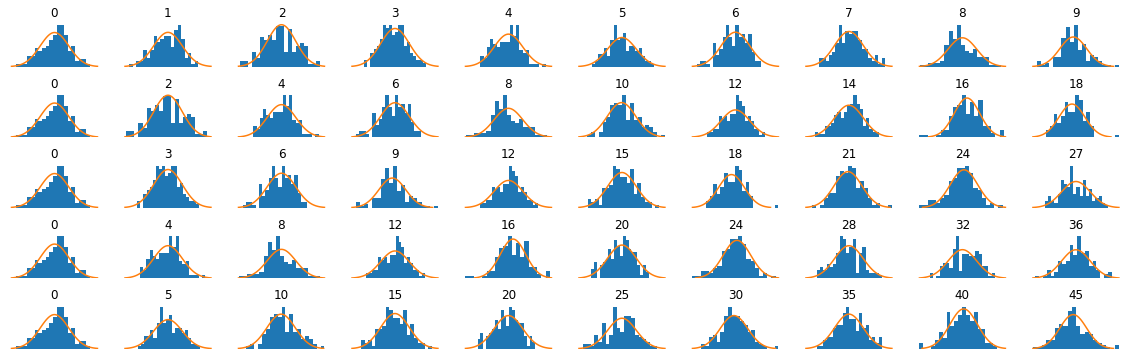

In [21]:
from scipy.stats import norm

num_rows = 5
num_cols = 10

# Get embeddings
z = encode_imgs(state, recons_batch, rng)

x = np.linspace(-3, 3, 100)
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 6))
fig.subplots_adjust(hspace=0.6)

for row in range(num_rows):
    for col in range(num_cols):
        ax = axes[row, col]
        ax.hist(z[:, row * col + col], density=True, bins=20)
        ax.plot(x, norm.pdf(x))
        ax.axis('off')
        ax.set_title(row * col + col)
        
plt.show()

## 9. Generate new faces

In [22]:
@jax.jit
def generate_imgs(state, embeddings):
    def decode_embs(vae):
        imgs = vae.decoder(embeddings, train=False)
        return imgs
    vae = VAE(EMBEDDING_DIM)
    return nn.apply(decode_embs, vae)({'params': state.params, 'batch_stats': state.batch_stats})

In [23]:
# randomly sample embeddings
grid_width, grid_height = (10, 3)
embeddings = np.random.normal(size=(grid_width * grid_height, EMBEDDING_DIM))

# generate images
generated_faces = generate_imgs(state, embeddings)

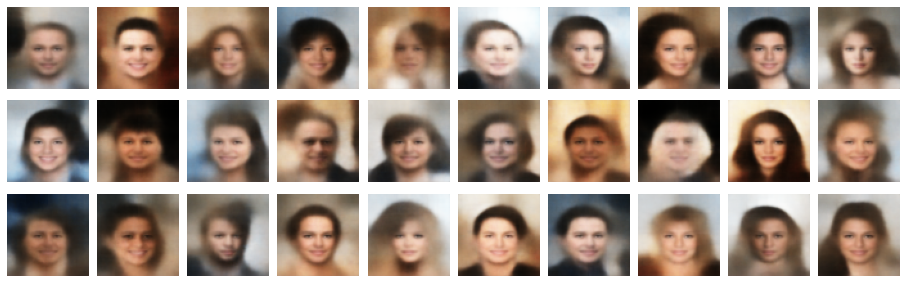

In [24]:
fig = plt.figure(figsize=(16, 5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis('off')
    ax.imshow(generated_faces[i])

## 10. Manipulate the images

In [25]:
from utils import *

label_file = DATA_FOlDER + 'list_attr_celeba.csv'
attributes = pd.read_csv(label_file)
print(attributes.columns)
attributes.head(10)

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
5,000006.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,1,-1,1,-1,-1,1
6,000007.jpg,1,-1,1,1,-1,-1,1,1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
7,000008.jpg,1,1,-1,1,-1,-1,1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
8,000009.jpg,-1,1,1,-1,-1,1,1,-1,-1,...,-1,1,-1,-1,1,-1,1,-1,-1,1
9,000010.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1


In [26]:
# Load the face data with label attached
LABEL = 'Smiling'
labelled_test = utils.image_dataset_from_directory(
    DATA_DIR,
    labels=attributes[LABEL].tolist(),
    color_mode='rgb',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=1024,
    validation_split=VALID_SPLIT,
    subset='validation',
    interpolation='bilinear'
)

labelled_ds = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 202599 files belonging to 2 classes.
Using 40519 files for validation.


### Getting feature vector

In [27]:
# Find the feature's vector
attribute_vec = get_vector_from_label(labelled_ds, EMBEDDING_DIM, LABEL, encode_imgs, state, rng)

label: Smiling
images | POS move | NEG move | distance | 𝛥 distance:
    71 |    2.026 |    1.662 |    2.588 |    2.588
   388 |    0.228 |    0.248 |    1.621 |   -0.036
   681 |    0.142 |    0.143 |    1.605 |   -0.054
   962 |    0.087 |    0.093 |    1.506 |    0.003
  1245 |    0.075 |    0.074 |    1.490 |   -0.013
  1571 |    0.055 |    0.061 |    1.450 |   -0.012
  1875 |    0.047 |    0.049 |    1.405 |   -0.008
  2175 |    0.039 |    0.040 |    1.378 |   -0.002
Found the Smiling vector


### Feature transitioning

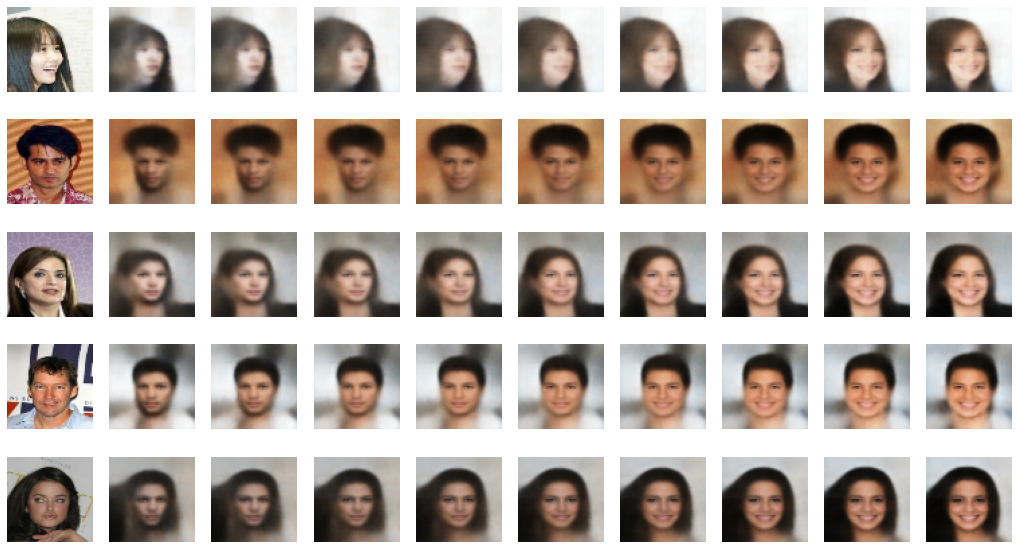

In [28]:
# Plot generated feature transitions
add_vector_to_images(labelled_ds, attribute_vec, encode_imgs, generate_imgs, state, rng)

### Morph faces

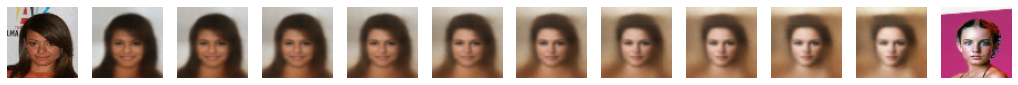

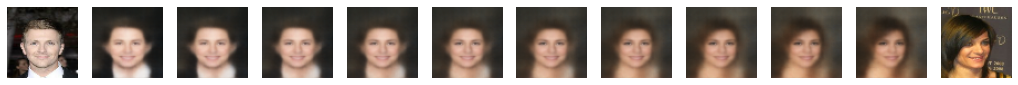

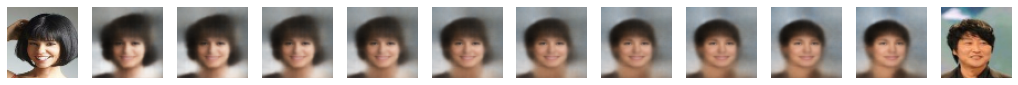

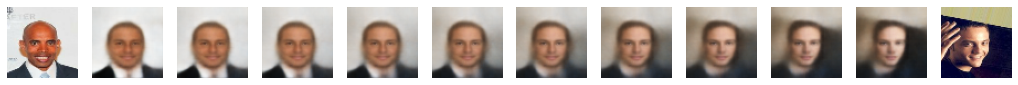

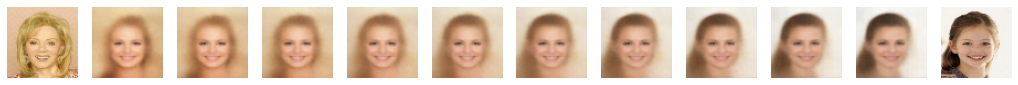

In [29]:
for _ in range(5):
    morph_faces(labelled_ds, encode_imgs, generate_imgs, state, rng)